# Lego Sorting
By Amy Phung and Case Zito

In this project, we wanted to explore the possibility of sorting legos by size using machine learning on images of Legos. To simplify our model, we focused on classifying legos by size (EX: 2x1). Our goal was to be accurate in classifying legos from our dataset, and be able to classify random legos from the outside world.

## Background
<!-- TODO: Case -->

<!-- data we had, what the algortihm would need, how it could be tested, implications, stakeholders, process, method -->
**Dataset:** 
To get the training and validation dataset for legos, we used this kaggle dataset: https://www.kaggle.com/pacogarciam3/lego-vs-generic-brick-image-recognition

The kaggle dataset has base and cropped images of legos with 6 different brick types (sizes) and 2 different brands (brick or lego). It gives an image key that gives a file name and classifies its brand, type, and what data set its from.

**Algorithm:**
We decided to use a convolutional neural net to classify cropped images of legos as their size. After training the convolutional neural net on the training set, we wanted to test the accuracy on the test set, and then test its accuracy on outside images of legos.

**Implications and Stakeholders:**
From research and conversations, we learned that lego bricks are often resold once reused for a very low price and usually by the pound. These legos sell for more if they are sorted, and some people sort them by hand to make a small profit on them. A possibility for this lego sort algorithm would be to make a sorter using a camera and something to separate them out brick by brick so they could be classified one by one. It would take some amount of engineering background and ability to put a camera and this algorithm together, so not everyone would be able to access this. This makes possible stakeholders need a base level of technical knowledge and money in order to use it.

One implication given these stakeholders would be that people who cannot use the software and sort by hand would be slower. If a person used our software and scaled it up to a large amount of legos, they could take those money away from people who are poorer or less engineering educated. This is a possible concern we would have for this algorithm, though on the other side it would mean less time and effort needed to sort legos.

**Process:**
To create our algorithm, we decided to use pytorch for convolutional neural nets (CNN). We saw some past projects that used pytorch for image classification successfully. The python library pytorch has in built features such as torchvision datasets, which put files into an easy to use python class. It also has tensors for holding lists of pixel values and built in layers that can be called for a CNN.  

## Set-up:

### **Imports:**

In [84]:
import gdown
import pandas as pd

!pip install torchviz
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torchviz import make_dot
import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import VisionDataset
import torchvision.transforms as transforms
import torch.optim as optim
import cv2
from PIL import Image

from glob import glob
from imageio import imread
import matplotlib.pyplot as plt
import numpy as np # we always love numpy
import time
from google.colab.patches import cv2_imshow

### **Image and key loading:**

In [85]:
gdown.download('https://drive.google.com/uc?authuser=0&id=1Z_rAAy-3UCK3yy-c9_Mxnx7Z34oxGwNL&export=download', 
               'lego-vs-generic-brick-image-recognition.zip', False)
gdown.download('https://drive.google.com/uc?authuser=0&id=1U1JpP4fH1NgsminyKKF9BDdKUumdGhB1&export=download',
             'ImageKey.csv', False)
gdown.download('https://drive.google.com/uc?authuser=0&id=1Ln4QzD_ZLSxjo-5SNpQEmI8WgcN9J9VK&export=download',
             'EvaluationKey.csv', False)


image_key = pd.read_csv('ImageKey.csv')
evaluation_key = pd.read_csv('EvaluationKey.csv')

Downloading...
From: https://drive.google.com/uc?authuser=0&id=1Z_rAAy-3UCK3yy-c9_Mxnx7Z34oxGwNL&export=download
To: /content/lego-vs-generic-brick-image-recognition.zip
1.65GB [00:10, 151MB/s]
Downloading...
From: https://drive.google.com/uc?authuser=0&id=1U1JpP4fH1NgsminyKKF9BDdKUumdGhB1&export=download
To: /content/ImageKey.csv
5.35MB [00:00, 163MB/s]
Downloading...
From: https://drive.google.com/uc?authuser=0&id=1Ln4QzD_ZLSxjo-5SNpQEmI8WgcN9J9VK&export=download
To: /content/EvaluationKey.csv
100%|██████████| 224k/224k [00:00<00:00, 56.3MB/s]


In [0]:
# Unzip datasets
!unzip -qq -o lego-vs-generic-brick-image-recognition.zip
# Unzip photo directories
#!unzip -qq -o Base\ Images.zip
!unzip -qq -o Cropped\ Images.zip

## Dataset


We used the torchvision dataset class for our images. It has in built framework to take filenames as load images, transform those images (like center-cropping), and classify images based on a given key. 

In the code below, we create a LegoData class from the VisionDataset class. The class takes in a root directory, a key, and what to transform the images by. We get the possible classes for the images based on the key (image_key). The getitem function allows us to load an image from the dataset based on its stored file path, get its class, and transform the image. The getitem function is helpful later on for visualizing specific images and getting the given class for a training image.


In [0]:
def getFileName(filepath):
  #gets 
  idx = filepath.rfind("/")
  return filepath[idx+1:]

def show_image(img_tensor):
  # Displays image based on its pixel values
  plt.imshow(img_tensor.transpose(0,2).transpose(0,1)) #reorder tensor dimensions for imshow
  plt.axis('off')
  plt.show()

class LegoData(VisionDataset):
  """
  Dataset class for the lego data
  
  Args:
    img_path (string): Filepath for images (ex: Base Images/Legos/*.jpg)
    key_df (pandas DataFrame): Dataframe containing columns Folder1	Folder2	
                               Picture Group	Timestamp	Image	Background 
                               Capture	Brand	Brick
  """
  def __init__(self, filepaths, key_df, transform=None, target_transform=None):
      super(LegoData, self).__init__('.',
                                     transform=transform,
                                     target_transform=target_transform)

      self.filepaths = filepaths
      self.key_df = key_df
      self.transform = transform
      self.target_transform = target_transform
      
      # self.classes = key_df.Brick.unique() would work for train and test set
      # Hardcoded classes since external image dataset does not have correct class
      self.classes = np.array(['2x2 L', '1x4', '1x1', '2x2', '2x3', '1x2'])
  
  def __getitem__(self, index):
      filepath = self.filepaths[index]
      
      img = Image.open(filepath)      
    
      # Get index of row for matching filepath
      key_idx = self.key_df[self.key_df['Image']==getFileName(filepath)].index.item()
      
      # Get corresponding lego class for file
      img_class = self.key_df.Brick[key_idx]

      # Get int representing lego class
      target = int(np.where(self.classes == img_class)[0])
      # apply transformations if they exist (this is useful for images)
      if self.transform is not None:
          img = self.transform(img)

      # apply target transformations if they exist
      if self.target_transform is not None:
          target = self.target_transform(target)
      
      return img, target

  def __len__(self):
      return len(self.filepaths)

After creating the class, we then create our train set and test set instances of the class. Our transform downsizes the images to be easier to process and makes the pixels a tensor for later evaluation. The filepath list is found based on all the filenames for cropped image legos. We also filtered out all images that had just a background rather than a lego, to focus on getting our algorithm to work best on legos, with the assumption that it would not be fed any incorrect data.

In [0]:
# Get images for train and test data sets and make them LegoData datasets
transform = transforms.Compose([#transforms.CenterCrop((200,200)), # Crop center of image
                                 transforms.Resize((32,32)), # Downsample image
                                 transforms.ToTensor()])     # Make pixel values a tensor
    
raw_train_filepath_list = glob("Cropped Images/Legos/*.jpg")
filtered_train_filepath_list = [x for x in raw_train_filepath_list if not 'bg' in x] # Remove background-only images
raw_test_filepath_list = glob("Cropped Images/Evaluation Set/*.jpg")
filtered_test_filepath_list = [x for x in raw_test_filepath_list if not 'bg' in x]

train_set = LegoData(filtered_train_filepath_list, image_key, transform) # Makes a dataset from filepaths
test_set = LegoData(filtered_test_filepath_list, image_key, transform)

The code below devices how much of the train_set and test_set we will actually use to the run the model, and stores the image dimensions. This will be helpful later on when running the model.

In [0]:
# Set up variables of information from datasets for the CNN
im, target = train_set[0] # Use first image to get image size

img_dims = tuple(im.shape)
n_train_samples = int(len(train_set) * 0.5) # Number of images to use
n_test_samples = int(len(test_set) * 0.5)
classes = train_set.classes # Classes for different sizes of legos

train_sampler = SubsetRandomSampler(np.arange(n_train_samples, dtype=np.int64))
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))

### Verification:

To verify that the torch vision dataset is working correctly, we display the dataset information, and display example images from it.

In [90]:
train_set # Dataset information

Dataset LegoData
    Number of datapoints: 8344
    Root location: .
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

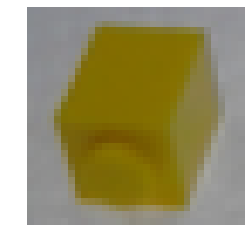

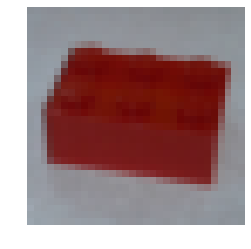

(3, 32, 32)


In [91]:
# Display a lego brick image
im, target = train_set[8300] # Can put any index here
im2, target2 = train_set[8000] # Second example

show_image(im)
show_image(im2)
print(tuple(im.shape))

## Convolutional Neural Net (CNN):

<!-- Neural Net Design
we used x filter with x error function-->

In [0]:
class LegoCNN(nn.Module):
  def __init__(self):
    super(LegoCNN, self).__init__()
    # Defines layer of CNN: convolutional -> pool -> maxpool -> fully connected reLU -> fully connected classes
    num_kernels = 16 # TODO: Why 16?
    self.conv1 = nn.Conv2d(img_dims[0], num_kernels, kernel_size=3, stride=1, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.maxpool_output_size = int(num_kernels * (img_dims[1] / 2) * (img_dims[2]/2))

    # fc = fully connected (first fully connected layer)
    fc1_size = 64 # TODO Why 64 here?
    self.fc1 = nn.Linear(self.maxpool_output_size, fc1_size)
    self.activation_func = torch.nn.ReLU() # bc math...
    # Convert fc to outputs that line up with number of classes
    fc2_size = len(classes)
    self.fc2 = nn.Linear(fc1_size, fc2_size)

    # Defines operations and returns output of model
  def forward(self, x):
    x = self.conv1(x)
    x = self.pool(x)
    x = self.activation_func(x)

    # Flattens output of conv, max pool, activation sequence
    x = x.view(-1, self.maxpool_output_size)
    x = self.fc1(x)
    x = self.activation_func(x)
    x = self.fc2(x)
    return x

  def get_loss(self, learning_rate):
    loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(self.parameters(), lr=learning_rate)
    return loss, optimizer

## Training and Loss Functions:

Once we have our dataset and model class created, we can then create functions for training and testing our model.

The function below is used for training the model, and finding the error/loss for the training and validation/testing data set.

In [0]:
def train_model(net, n_epochs, learning_rate, train_loader, test_loader):
    """ Train a the specified network.

        Outputs a tuple with the following four elements
        train_hist_x: the x-values (batch number) that the training set was 
            evaluated on.
        train_loss_hist: the loss values for the training set corresponding to
            the batch numbers returned in train_hist_x
        test_hist_x: the x-values (batch number) that the test set was 
            evaluated on.
        test_loss_hist: the loss values for the test set corresponding to
            the batch numbers returned in test_hist_x
    """ 
    loss, optimizer = net.get_loss(learning_rate)
    # Define some parameters to keep track of metrics
    print_every = 20
    idx = 0
    train_hist_x = []
    train_loss_hist = []
    test_hist_x = []
    test_loss_hist = []

    training_start_time = time.time()
    # Loop for n_epochs
    for epoch in range(n_epochs):
        # print("here1")
        running_loss = 0.0
        start_time = time.time()

        for i, data in enumerate(train_loader, 0):
             # Get inputs in right form
            inputs, labels = data
            # Labels are converted to a tensor, instead of ints in a list
            labels = torch.LongTensor(labels)
            # Wrap tensors in Variables
            inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)
            
            # In Pytorch, We need to always remember to set the optimizer gradients to 0 before we recompute the new gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = net(inputs)
            
            # Compute the loss and find the loss with respect to each parameter of the model
            loss_size = loss(outputs, labels)
            loss_size.backward()
            
            # Change each parameter with respect to the recently computed loss.
            optimizer.step()

            # Update statistics
            running_loss += loss_size.data.item()
            
            # Print every 20th batch of an epoch
            if (i % print_every) == print_every-1:
                print("Epoch {}, Iteration {}\t train_loss: {:.2f} took: {:.2f}s".format(
                    epoch + 1, i+1,running_loss / print_every, time.time() - start_time))
                # Reset running loss and time
                train_loss_hist.append(running_loss / print_every)
                train_hist_x.append(idx)
                running_loss = 0.0
                start_time = time.time()
            idx += 1

        # At the end of the epoch, do a pass on the test set
        total_test_loss = 0
        for inputs, labels in test_loader:
            # Wrap tensors in Variables
            inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

            # Forward pass
            test_outputs = net(inputs)
            test_loss_size = loss(test_outputs, labels)
            total_test_loss += test_loss_size.data.item()
        test_loss_hist.append(total_test_loss / len(test_loader))
        test_hist_x.append(idx)
        print("Validation loss = {:.2f}".format(
            total_test_loss / len(test_loader)))

    print("Training finished, took {:.2f}s".format(
        time.time() - training_start_time))
    return train_hist_x, train_loss_hist, test_hist_x, test_loss_hist

The function below is used to evaluate the accuracy of the model for predicting outputs. It compares the output labels (what size the lego was predicted as) to the given label for the input (what size the lego actually is) and tallies the number of correct guesses.

In [0]:
def get_accuracy(net, loader):
    n_correct = 0
    n_total = 0
    for i, data in enumerate(loader, 0):
        # Get inputs in right form
        inputs, labels = data
        inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

        # Forward pass
        outputs = net(inputs)
        n_correct += np.sum(np.argmax(outputs.cpu().detach().numpy(), axis=1) == labels.cpu().numpy())
        n_total += labels.shape[0]
    return n_correct/n_total

This function uses the last two functions to train the model and then return the accuracy of the training and test set.

In [0]:
def runTesting(train_size, test_size, net, train_loader=None, test_loader=None):
  print("Train size: " + str(train_size))
  print("Test size: " + str(test_size))
  # Define training parameters
  training_batch_size = train_size # Number of images to use in mini-batch to train  
  testing_batch_size = test_size #default: 128 # Number of images to use in mini-batch to test

  learning_rate = 1e-2  # TODO: how does this change things
  n_epochs = 3 #10 # TODO: orignal was 10, maybe try making it 10 again?
  # Get our data into the mini batch size that we defined
  
  if (train_loader == None):
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=training_batch_size, sampler=train_sampler, num_workers=2)
    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=testing_batch_size, sampler=test_sampler, num_workers=2)

  train_hist_x, train_loss_hist, test_hist_x, test_loss_hist = train_model(net, n_epochs, learning_rate, train_loader, test_loader)
  print("Train accuracy is", get_accuracy(net, train_loader))
  print("Test accuracy is", get_accuracy(net, test_loader))
  return train_hist_x, train_loss_hist, test_hist_x, test_loss_hist

#### Model Training + Testing

To train a model, we use this code which calls the above functions and returns the accuracy of the model.

In [96]:
size1 = 16
size2 = 16

# device = 'cuda' # 'cpu' if we want to not use the gpu
device='cuda'
# Initialize the model, loss, and optimization function
net = LegoCNN()
# This tells our model to send all of the tensors and operations to the GPU (or keep them at the CPU if we're not using GPU)
net.to(device)
training_batch_size = size1
testing_batch_size = size2
train_hist_x, train_loss_hist, test_hist_x, test_loss_hist = runTesting(size1, size2, net)

Train size: 16
Test size: 16
Epoch 1, Iteration 20	 train_loss: 1.91 took: 1.54s
Epoch 1, Iteration 40	 train_loss: 1.78 took: 1.42s
Epoch 1, Iteration 60	 train_loss: 1.70 took: 1.36s
Epoch 1, Iteration 80	 train_loss: 1.55 took: 1.39s
Epoch 1, Iteration 100	 train_loss: 1.43 took: 1.42s
Epoch 1, Iteration 120	 train_loss: 1.40 took: 1.37s
Epoch 1, Iteration 140	 train_loss: 1.28 took: 1.41s
Epoch 1, Iteration 160	 train_loss: 1.20 took: 1.39s
Epoch 1, Iteration 180	 train_loss: 1.12 took: 1.42s
Epoch 1, Iteration 200	 train_loss: 1.13 took: 1.40s
Epoch 1, Iteration 220	 train_loss: 1.06 took: 1.37s
Epoch 1, Iteration 240	 train_loss: 0.99 took: 1.44s
Epoch 1, Iteration 260	 train_loss: 1.00 took: 1.33s
Validation loss = 0.96
Epoch 2, Iteration 20	 train_loss: 0.84 took: 1.53s
Epoch 2, Iteration 40	 train_loss: 0.91 took: 1.42s
Epoch 2, Iteration 60	 train_loss: 0.79 took: 1.36s
Epoch 2, Iteration 80	 train_loss: 0.73 took: 1.42s
Epoch 2, Iteration 100	 train_loss: 0.93 took: 1.46s
Ep

#### Loss Visualization

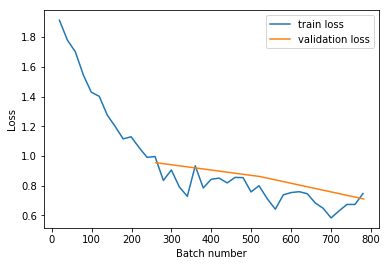

In [97]:
plt.plot(train_hist_x,train_loss_hist)
plt.plot(test_hist_x,test_loss_hist)
plt.legend(['train loss', 'validation loss'])
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.show()

#### Individual Image Verification

To view results for individual images, we can use the following functions to apply the model to single images and compare the prediction to the expected results

In [0]:
def examine_label(idx, dataset):
    image, label = dataset[idx]
    class_scores = net(Variable(image.unsqueeze(0)).to(device))
    print(class_scores.cpu().detach().numpy())
    prediction = np.argmax(class_scores.cpu().detach().numpy())
    classes = dataset.classes
    print(classes)
    disp_image(image, label, classes, prediction)

def disp_image(image, class_idx, classes, predicted=None):
    # need to reorder the tensor dimensions to work properly with imshow
    plt.imshow(image.transpose(0,2).transpose(0,1))
    plt.axis('off')
    if predicted:
        plt.title("Actual: " + classes[class_idx] + "     Predicted: " + classes[predicted])
    else:
        plt.title("Actual: " + classes[class_idx])
    plt.show()

[[ -2.5551221 -23.259989    7.833107   -2.2082334  -6.442236    4.6850023]]
['2x2 L' '1x4' '1x1' '2x2' '2x3' '1x2']


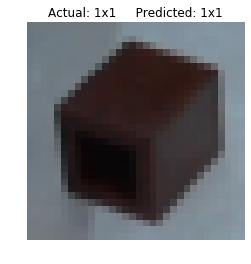

In [99]:
examine_label(650, train_set) # Can put any valid index here

# 3 Interesting things

## Batch Size


We wanted to explore the impact of batch size on our training times and resulting accuracy. To do this, we tried using common batch sizes as described by [this site](https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/) for our test and training batch sizes. We ran this test using batch sizes 16, 32, 64, and 128 using our one-layer convolutional nerual network. The code we used to do this is included in the cell below: 

In [0]:
sizes = [32,64,16,128];
for size1 in sizes:
  for size2 in sizes:
    # device = 'cuda' # 'cpu' if we want to not use the gpu
    device='cuda'
    # Initialize the model, loss, and optimization function
    net = LegoCNN()
    # This tells our model to send all of the tensors and operations to the GPU (or keep them at the CPU if we're not using GPU)
    net.to(device)
    #batch size for this run is set
    training_batch_size = size1
    testing_batch_size = size2
    #creates the train and test loader for this batch_size
    train_loader = torch.utils.data.DataLoader(
      train_set, batch_size=training_batch_size, sampler=train_sampler, num_workers=2)
    test_loader = torch.utils.data.DataLoader(
      test_set, batch_size=testing_batch_size, sampler=test_sampler, num_workers=2)
    #run the training and find accuracy for this batch size
    runTesting(size1, size2, net, train_loader, test_loader)

The results of this test can be summarized by the graphics below:

In [102]:
gdown.download('https://drive.google.com/uc?authuser=0&id=1jLb7hAHzX8iQbOGCFjUKQ5-EzzslDi-d&export=download',
             'batchResults.csv', False)

batch_results = pd.read_csv('batchResults.csv')

Downloading...
From: https://drive.google.com/uc?authuser=0&id=1jLb7hAHzX8iQbOGCFjUKQ5-EzzslDi-d&export=download
To: /content/batchResults.csv
100%|██████████| 683/683 [00:00<00:00, 540kB/s]


In [103]:
batch_results

,Train SIze,Test Size,Time,Train Accuracy,Test Accuracy
0,16,16,64.07,0.774688,0.744681
1,32,32,60.89,0.731783,0.721884
2,64,32,59.87,0.761985,0.714286
3,32,64,62.18,0.755992,0.706687
4,16,64,64.06,0.741850,0.683891
5,64,128,61.25,0.710930,0.662614
6,64,16,61.18,0.697028,0.661094
7,16,128,64.09,0.682886,0.653495
8,32,16,61.35,0.705896,0.645897
9,32,128,60.74,0.739693,0.636778


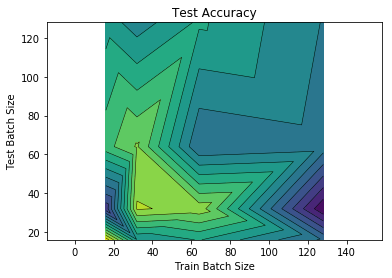

In [104]:
import matplotlib.tri as tri
import matplotlib.pyplot as plt

x = batch_results['Train SIze']
y = batch_results['Test Size']
z = batch_results['Test Accuracy']

plt.tricontour(x, y, z, 15, linewidths=0.5, colors='k')
plt.tricontourf(x, y, z, 15)

plt.xlabel("Train Batch Size")
plt.ylabel("Test Batch Size")
plt.title("Test Accuracy")
plt.axis('equal')

plt.show()

In general, we found that lower batch sizes were better and that the test batch size should be equal to or larger than the train batch size for good results. Separately, when we tested lower batch sizes than 16, the results became much poorer, so we stuck to testing numbers larger than 16

## Adding in photos outside of defined classes

Another thing we found interesting to explore was adding in our own photos that we didn't have training data for and seeing what it would be classified as. Interestingly enough, we found that our net classified those legos in a similar way we would've if we didn't know about that particular lego brick. 

#### Setup Code

In [0]:
gdown.download('https://drive.google.com/uc?authuser=0&id=1FKDwwIL1OHU05TM3AcWBCBARsPSLcDIa&export=download', 
               'testset2.zip', False)

gdown.download('https://drive.google.com/uc?authuser=0&id=1xclKETN0xB-wLZvhiacRIC6GYtgysCVg&export=download',
             'testset2.csv', True)
custom_set_key = pd.read_csv('testset2.csv')

Downloading...
From: https://drive.google.com/uc?authuser=0&id=1FKDwwIL1OHU05TM3AcWBCBARsPSLcDIa&export=download
To: /content/testset2.zip
8.01MB [00:00, 19.7MB/s]


In [0]:
! mkdir custom_set
! cd custom_set && unzip -qq -o ../testset2.zip

In [0]:
custom_filepath_list = glob("custom_set/*.jpg")

transform = transforms.Compose([transforms.CenterCrop((2000,2000)), # Crop center of image
                                 transforms.Resize((32,32)), # Downsample image
                                 transforms.ToTensor()])     # Make pytorch happy
new_filepath_list = glob("custom_set/*.jpg")

new_set = LegoData(new_filepath_list, custom_set_key, transform) 

#### Categorization Testing

We loaded in our own dataset and observed how it held up when we applied the model. Something interesting to note was that the cropping of the image had a significant impact on the accuracy of our custom dataset. For future iterations, making the model less depndent on location of the brink in frame would make it more robust.

Here's an example of an accurately identified brick from our custom set.

[[-0.21938872 -1.5419695  -3.7131302  -4.1204305   3.568063    0.15124793]]
['2x2 L' '1x4' '1x1' '2x2' '2x3' '1x2']


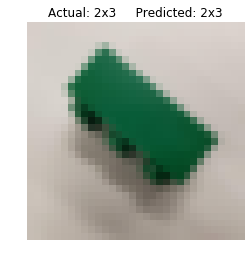

In [112]:
examine_label(20, new_set) # Can put any valid index here

In the image below, we took an image of a 2x4 which is not one of the types of bricks the model is trained to recognize. It is interesting to note that from the side view, this visually looks similar to a 1x4, which matches the prediction

[[  0.91294354   4.1905684   -7.9109936  -13.828257     2.7873309
    2.0974994 ]]
['2x2 L' '1x4' '1x1' '2x2' '2x3' '1x2']


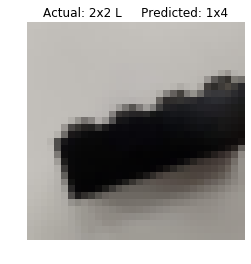

In [111]:
examine_label(16, new_set) # Can put any valid index here

Contrary to the side view, the top view of a 2x4 looks a lot more like a 2x3 than a 1x4, which is also evident in its prediction.

[[-1.1322892 -7.7903132 -5.115532  -8.856818   3.792269   2.6816404]]
['2x2 L' '1x4' '1x1' '2x2' '2x3' '1x2']


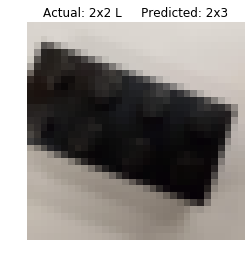

In [116]:
examine_label(18, new_set) # Can put any valid index here

## Visualizing Activation Gradients

To get a better understanding of what our model was looking at when it classified bricks in a certain way, we chose to visualize the activation gradients to see what the model made it's decisions based off of. Since the gradients are focused on the brick itself and not on extraneous background pixels, this provides validation that our model works as expected.

In [0]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


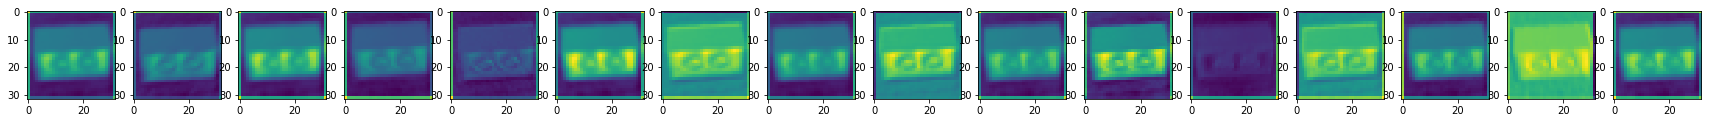

In [0]:
net.conv1.register_forward_hook(get_activation('conv1'))
data, _ = train_set[0]
data.unsqueeze_(0)
# print(type(data))
device = "cuda"
data = torch.tensor(data, device=device)
output = net(data)

act = activation['conv1'].squeeze()
fig, axarr = plt.subplots(1,act.size(0))
# fig = matplotlib.pyplot.gcf()
fig.set_size_inches(30, 20)
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx].cpu())

# Results
Overall, our results were rather promising. Our models often had around a 70-75% training accuracy and a 65-70% testing accuracy, with our best model having an 80% training accuracy and a 75% testing accuracy. 

The code below trains a new model based on our input parameters and computes the train and test accuracy. A graph of our loss is also included below.

Train size: 16
Test size: 16
Epoch 1, Iteration 20	 train_loss: 2.09 took: 1.50s
Epoch 1, Iteration 40	 train_loss: 1.79 took: 1.42s
Epoch 1, Iteration 60	 train_loss: 1.75 took: 1.37s
Epoch 1, Iteration 80	 train_loss: 1.77 took: 1.45s
Epoch 1, Iteration 100	 train_loss: 1.65 took: 1.43s
Epoch 1, Iteration 120	 train_loss: 1.60 took: 1.40s
Epoch 1, Iteration 140	 train_loss: 1.39 took: 1.47s
Epoch 1, Iteration 160	 train_loss: 1.27 took: 1.41s
Epoch 1, Iteration 180	 train_loss: 1.21 took: 1.45s
Epoch 1, Iteration 200	 train_loss: 1.26 took: 1.42s
Epoch 1, Iteration 220	 train_loss: 1.23 took: 1.41s
Epoch 1, Iteration 240	 train_loss: 1.23 took: 1.42s
Epoch 1, Iteration 260	 train_loss: 1.06 took: 1.44s
Validation loss = 1.02
Epoch 2, Iteration 20	 train_loss: 1.01 took: 1.52s
Epoch 2, Iteration 40	 train_loss: 1.04 took: 1.47s
Epoch 2, Iteration 60	 train_loss: 1.10 took: 1.45s
Epoch 2, Iteration 80	 train_loss: 1.00 took: 1.40s
Epoch 2, Iteration 100	 train_loss: 0.88 took: 1.44s
Ep

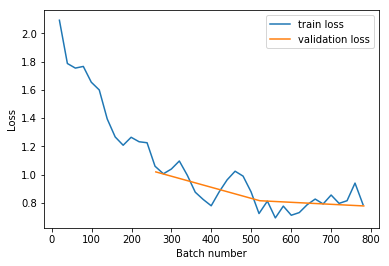

In [0]:
#Basic run
#batch sizes
training_batch_size = 16
testing_batch_size = 16
#set up for train and test
train_loader = torch.utils.data.DataLoader(
      train_set, batch_size=training_batch_size, sampler=train_sampler, num_workers=2)
test_loader = torch.utils.data.DataLoader(
      test_set, batch_size=testing_batch_size, sampler=test_sampler, num_workers=2) # TODO: Why the 128
# device = 'cuda' to use gpu
device='cuda'
# Initialize the model, loss, and optimization function
net = LegoCNN()
# This tells our model to send all of the tensors and operations to the GPU (or keep them at the CPU if we're not using GPU)
net.to(device)

train_hist_x, train_loss_hist, test_hist_x, test_loss_hist = runTesting(
    training_batch_size, testing_batch_size, net, train_loader, test_loader)

plt.plot(train_hist_x,train_loss_hist)
plt.plot(test_hist_x,test_loss_hist)
plt.legend(['train loss', 'validation loss'])
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.show()